In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import gudhi as gh
import networkx as nx

import itertools

from matplotlib import pyplot as plt

from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points

# Delauney Complex

## Define a Complex

In [3]:
def assign_filtration(stree: gh.SimplexTree, filtration):
    # returns the SimplexTree with the given filtration
    stree_res = gh.SimplexTree()
    for (simplex, _), value in zip(stree.get_simplices(), filtration):
        stree_res.insert(simplex, value)
    return stree_res

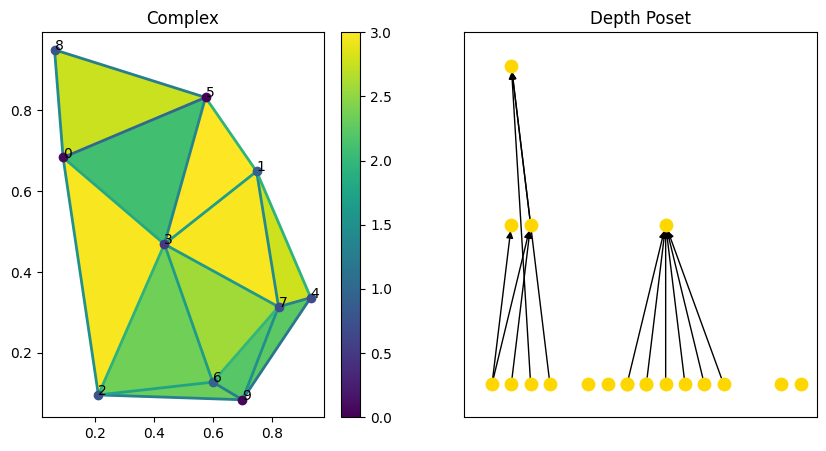

In [4]:
npoints = 10

points = np.random.random([npoints, 2])
stree = gh.AlphaComplex(points).create_simplex_tree()

simplices = np.array([simplex for simplex, _ in stree.get_simplices()], dtype=object)
dims = np.array([len(simplex) - 1 for simplex in simplices])

filtration = np.random.random(len(simplices)) + dims

stree = assign_filtration(stree, filtration)
dp = DepthPoset.from_simplex_tree(stree)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title('Complex')
sm = plot_filtred_complex2d(stree, points, ax=axs[0], vmin=0, vmax=3)
plt.colorbar(sm, ax=axs[0])
enumerate_points(points, ax=axs[0])

axs[1].set_title('Depth Poset')
nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(), ax=axs[1], 
                 node_color='gold', node_size=80, with_labels=False, hide_ticks=True)

plt.show()

## Height

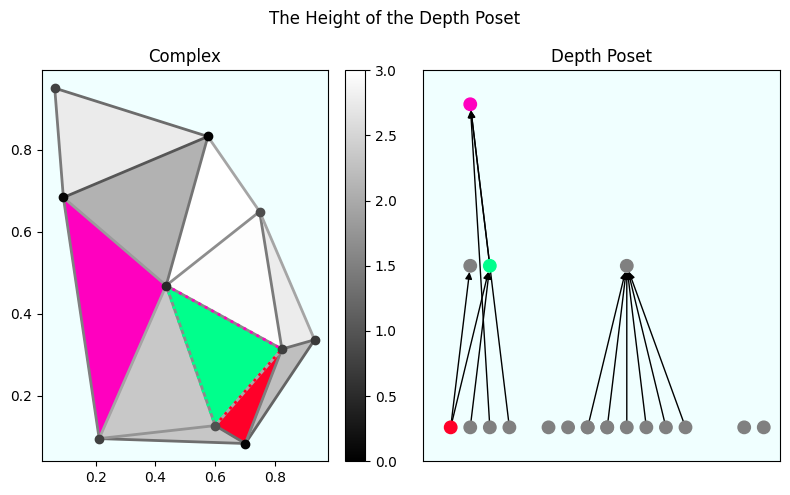

In [5]:
cmap = plt.get_cmap('gist_rainbow')
chain = np.array(nx.dag_longest_path(dp.get_transitive_reduction()))
chain_colors = cmap(np.linspace(0, 1, len(chain)))

node_colors = ['grey' for node in dp.nodes]
for i, node in enumerate(dp.nodes):
    if node in chain:
        node_colors[i] = chain_colors[np.argwhere(chain == node)[0][0]]

fig, axs = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle('The Height of the Depth Poset')

axs[0].set_title('Complex')
axs[0].set_facecolor('azure') 
sm = plot_filtred_complex2d(stree, points, ax=axs[0], vmin=0, vmax=3, cmap='grey')
plt.colorbar(sm, ax=axs[0])
for node, color in zip(chain, chain_colors):
    for simplex in node.source:
        plot_simplex(list(simplex), points, color, ax=axs[0], marker='*', linestyle=':')


axs[1].set_title('Depth Poset')
axs[1].set_facecolor('azure') 
nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(), ax=axs[1], 
                 node_color=node_colors, node_size=80, with_labels=False, hide_ticks=True)

plt.tight_layout()
plt.show()

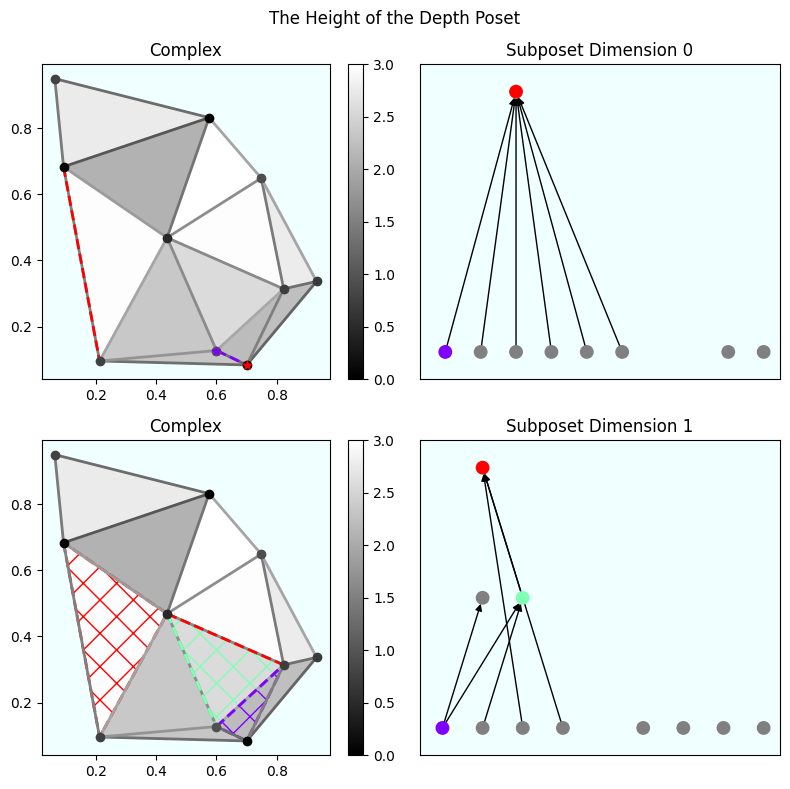

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('The Height of the Depth Poset')


cmap = plt.get_cmap('gist_rainbow')
cmap = plt.get_cmap('rainbow')

for dim in range(2):
    dpi = dp.subposet_dim(dim)
    
    chain = np.array(nx.dag_longest_path(dpi.get_transitive_reduction()))
    chain_colors = cmap(np.linspace(0, 1, len(chain)))

    node_colors = ['grey' for node in dpi.nodes]
    for i, node in enumerate(dpi.nodes):
        if node in chain:
            node_colors[i] = chain_colors[np.argwhere(chain == node)[0][0]]
    

    axs[dim, 0].set_title('Complex')
    axs[dim, 0].set_facecolor('azure') 
    sm = plot_filtred_complex2d(stree, points, ax=axs[dim, 0], vmin=0, vmax=3, cmap='grey')
    plt.colorbar(sm, ax=axs[dim, 0])
    for node, color in zip(chain, chain_colors):
        for simplex in node.source:
            plot_simplex(list(simplex), points, color, ax=axs[dim, 0], marker='*', linestyle='--', hatch='x')

    axs[dim, 1].set_title(f'Subposet Dimension {dim}')
    axs[dim, 1].set_facecolor('azure') 
    nx.draw_networkx(dpi.get_transitive_reduction(), pos=dpi.hasse_layout(), ax=axs[dim, 1], 
                     node_color=node_colors, node_size=80, with_labels=False, hide_ticks=True)

plt.tight_layout()
plt.show()

## Width

In [7]:
def is_antichain(nodes, g: nx.DiGraph):
    for e0, e1 in g.edges:
        if (e0 in nodes) and (e1 in nodes):
            return False
    return True

def iterate_antichains(g: nx.DiGraph):
    for i in range(len(g.nodes), 1, -1):
        for combination in itertools.combinations(g.nodes, i):
            if is_antichain(combination, g):
                yield list(combination)

def get_maximal_antichain(g: nx.DiGraph):
    antichain = []
    for potential_antichain in iterate_antichains(g):
        if len(potential_antichain) > len(antichain):
            antichain = potential_antichain
    return antichain

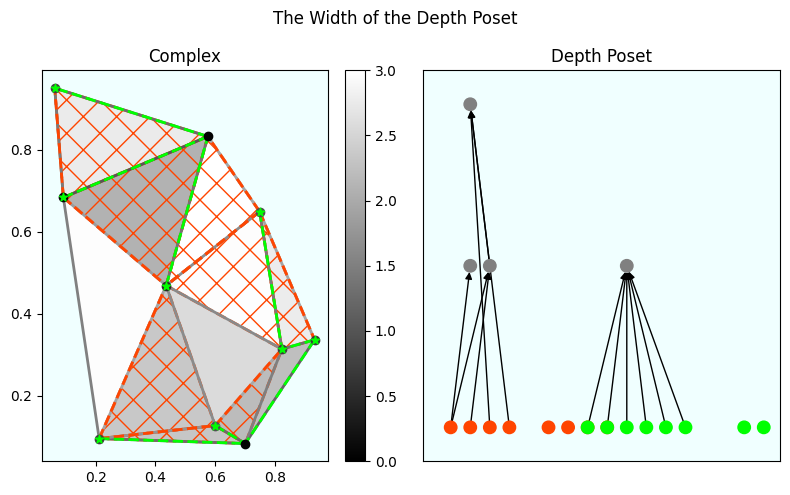

In [8]:
dp0 = dp.subposet_dim(0)
dp1 = dp.subposet_dim(1)

antichain0 = get_maximal_antichain(dp0.get_transitive_closure())
antichain1 = get_maximal_antichain(dp1.get_transitive_closure())

color = 'grey'
color0 = 'lime'
color1 = 'orangered'
node_colors = [color0 if node in antichain0 else color1 if node in antichain1 else color for node in dp.nodes]


fig, axs = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle('The Width of the Depth Poset')

axs[0].set_title('Complex')
axs[0].set_facecolor('azure') 
sm = plot_filtred_complex2d(stree, points, ax=axs[0], vmin=0, vmax=3, cmap='grey')
plt.colorbar(sm, ax=axs[0])
for node in antichain1:
    for simplex in node.source:
        plot_simplex(list(simplex), points, color=color1, ax=axs[0], marker='*', linestyle='--', hatch='x')
for node in antichain0:
    for simplex in node.source:
        plot_simplex(list(simplex), points, color=color0, ax=axs[0], marker='*', linestyle='--', hatch='x')


axs[1].set_title('Depth Poset')
axs[1].set_facecolor('azure') 
nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(), ax=axs[1], 
                 node_color=node_colors, node_size=80, with_labels=False, hide_ticks=True)

plt.tight_layout()
plt.show()

# Function-like
Here I am going to define 1-dimensional complex

In [9]:
def plot_function_like_simplex(s, filtrations0, filtrations1, ax=None, n=100, **kwargs):
    if ax is None:
        ax = plt.gca()
    if len(s) == 1:
        x = s[0]
        y = filtrations0[x]
        ax.scatter(x, y, **kwargs)
    if len(s) == 2:
        i0, i1 = s
        y0 = filtrations0[i0]
        y1 = filtrations1[i0]
        y2 = filtrations0[i1]
        t = np.linspace(0, 1, n)
        x = np.concatenate([i0 + 0.5*t, i0 + 0.5 + 0.5*t])
        t = 0.5*(np.sin(-0.5*np.pi + np.pi*t) + 1)
        t = t**1.5
        y = np.concatenate([y0*(1 - t) + y1*t, 
                            y1*(1 - t) + y2*t])
        ax.plot(x, y, **kwargs)

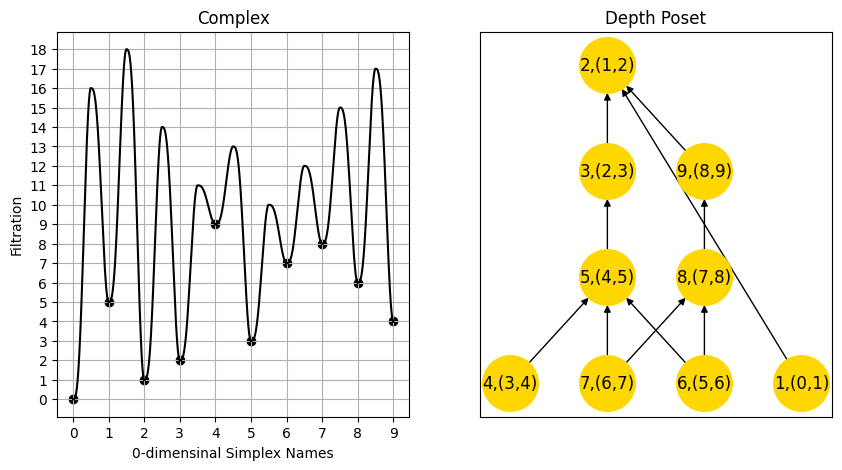

In [10]:
filtrations0 = [ 0,  5,  1,  2,  9,  3,  7,  8,  6,  4]
filtrations1 = [16, 18, 14, 11, 13, 10, 12, 15, 17]

stree = gh.SimplexTree()
for i, value in enumerate(filtrations0):
    s0 = [i]
    stree.insert(s0, value)
for i, value in enumerate(filtrations1):
    s1 = [i, i + 1]
    stree.insert(s1, value)

dp = DepthPoset.from_simplex_tree(stree)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title('Complex')
for s, value in stree.get_simplices():
    plot_function_like_simplex(s, filtrations0, filtrations1, color='black', ax=axs[0])
axs[0].set_xticks(filtrations0)
axs[0].set_yticks(filtrations0 + filtrations1)
axs[0].set_xlabel('0-dimensinal Simplex Names')
axs[0].set_ylabel('Filtration')
axs[0].grid(True)



axs[1].set_title('Depth Poset')
nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(), ax=axs[1], 
                 node_color='gold', node_size=1600, with_labels=True, hide_ticks=True)

plt.show()

## Height

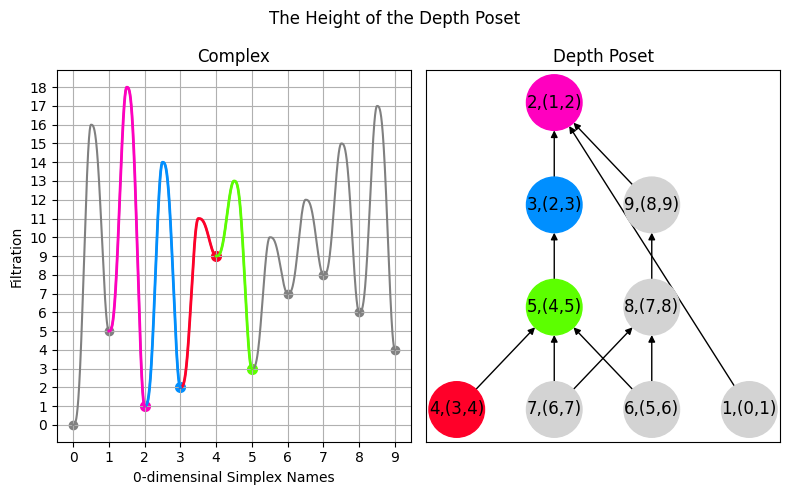

In [11]:
cmap = plt.get_cmap('gist_rainbow')
chain = np.array(nx.dag_longest_path(dp.get_transitive_reduction()))
chain_colors = cmap(np.linspace(0, 1, len(chain)))

node_colors = ['lightgrey' for node in dp.nodes]
for i, node in enumerate(dp.nodes):
    if node in chain:
        node_colors[i] = chain_colors[np.argwhere(chain == node)[0][0]]


fig, axs = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle('The Height of the Depth Poset')

axs[0].set_title('Complex')
for s, value in stree.get_simplices():
    plot_function_like_simplex(s, filtrations0, filtrations1, color='grey', ax=axs[0])
for node, color in zip(chain, chain_colors):
    for s in node.source:
        plot_function_like_simplex(s, filtrations0, filtrations1, color=color, ax=axs[0], linewidth=2)

axs[0].set_xticks(filtrations0)
axs[0].set_yticks(filtrations0 + filtrations1)
axs[0].set_xlabel('0-dimensinal Simplex Names')
axs[0].set_ylabel('Filtration')
axs[0].grid(True)



axs[1].set_title('Depth Poset')
nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(), ax=axs[1], 
                 node_color=node_colors, node_size=1600, with_labels=True, hide_ticks=True)

plt.tight_layout()
plt.show()

## Width

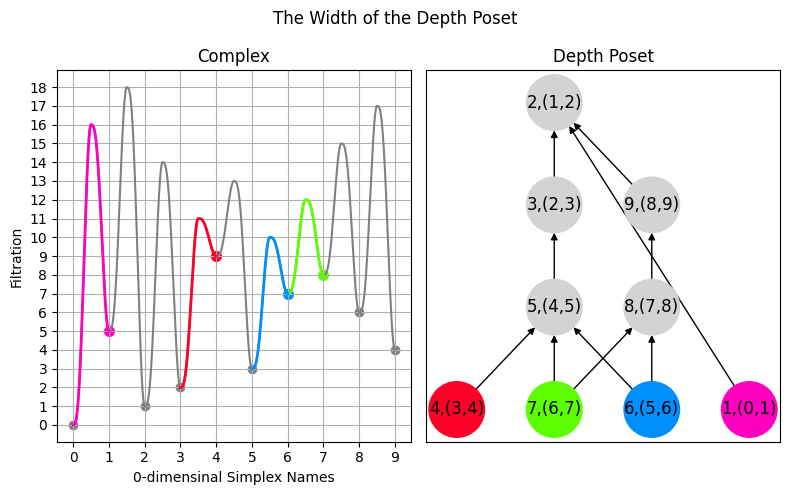

In [12]:
cmap = plt.get_cmap('gist_rainbow')

chain = np.array(get_maximal_antichain(dp.get_transitive_closure()))
chain_colors = cmap(np.linspace(0, 1, len(chain)))

node_colors = ['lightgrey' for node in dp.nodes]
for i, node in enumerate(dp.nodes):
    if node in chain:
        node_colors[i] = chain_colors[np.argwhere(chain == node)[0]]


fig, axs = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle('The Width of the Depth Poset')

axs[0].set_title('Complex')
for s, value in stree.get_simplices():
    plot_function_like_simplex(s, filtrations0, filtrations1, color='grey', ax=axs[0])
for node, color in zip(chain, chain_colors):
    for s in node.source:
        plot_function_like_simplex(s, filtrations0, filtrations1, color=color, ax=axs[0], linewidth=2)

axs[0].set_xticks(filtrations0)
axs[0].set_yticks(filtrations0 + filtrations1)
axs[0].set_xlabel('0-dimensinal Simplex Names')
axs[0].set_ylabel('Filtration')
axs[0].grid(True)



axs[1].set_title('Depth Poset')
nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(), ax=axs[1], 
                 node_color=node_colors, node_size=1600, with_labels=True, hide_ticks=True)

plt.tight_layout()
plt.show()

## Node Ancestors

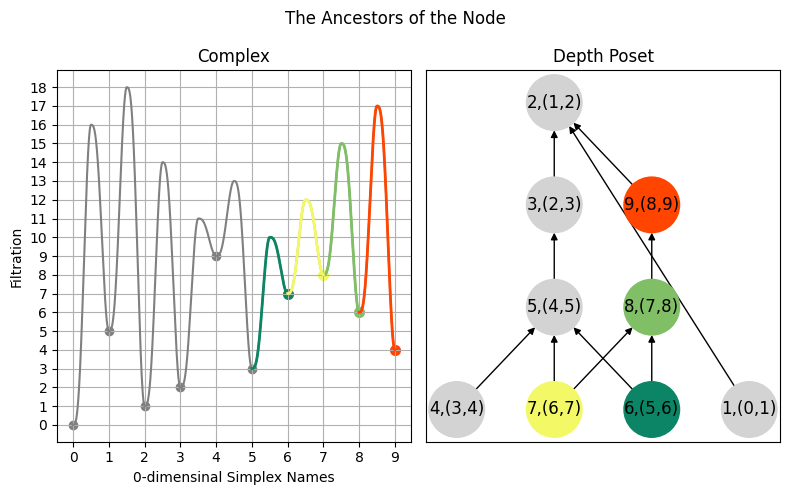

In [13]:
root = np.random.choice(list(set([e1 for e0, e1 in dp.edges])))

ancestors = list(set([e0 for e0, e1 in dp.get_transitive_closure().edges if e1 == root]))

root_color = 'orangered'
ancestors_colors = plt.get_cmap('summer')(0.05 + 0.9*np.linspace(0, 1, len(ancestors)))
ancestors_colors = ['#{:02x}{:02x}{:02x}'.format(*(color[:3]*255).astype(int)) for color in ancestors_colors]

node_colors = np.array(['lightgrey' for node in dp.nodes], dtype=object)
node_colors[np.array(dp.nodes) == root] = root_color
for node, color in zip(ancestors, ancestors_colors):
    node_colors[np.array(dp.nodes) == node] = color


fig, axs = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle('The Ancestors of the Node')

axs[0].set_title('Complex')
for s, value in stree.get_simplices():
    plot_function_like_simplex(s, filtrations0, filtrations1, color='grey', ax=axs[0])
for node, color in zip(np.append(ancestors, root), np.append(ancestors_colors, root_color)):
    for s in node.source:
        plot_function_like_simplex(s, filtrations0, filtrations1, color=color, ax=axs[0], linewidth=2)

axs[0].set_xticks(filtrations0)
axs[0].set_yticks(filtrations0 + filtrations1)
axs[0].set_xlabel('0-dimensinal Simplex Names')
axs[0].set_ylabel('Filtration')
axs[0].grid(True)



axs[1].set_title('Depth Poset')
nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(), ax=axs[1], 
                 node_color=node_colors, node_size=1600, with_labels=True, hide_ticks=True)

plt.tight_layout()
plt.show()

## Node Successors

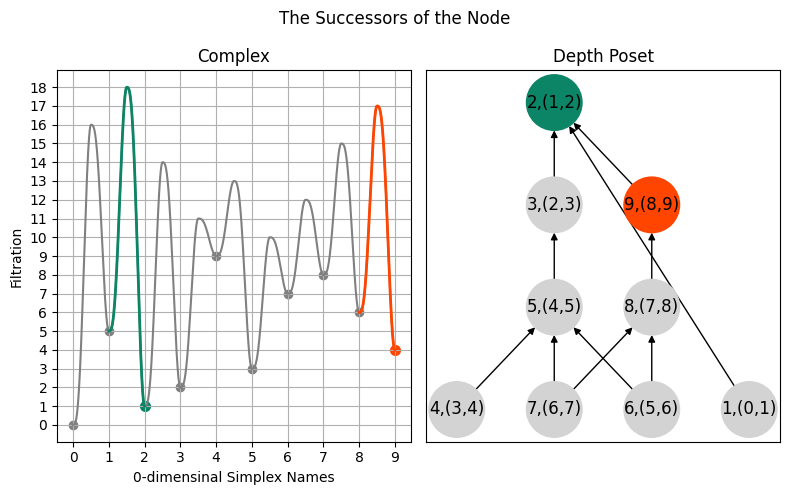

In [14]:
root = np.random.choice(list(set([e0 for e0, e1 in dp.edges])))

successors = list(set([e1 for e0, e1 in dp.get_transitive_closure().edges if e0 == root]))

root_color = 'orangered'
successors_colors = plt.get_cmap('summer')(0.05 + 0.9*np.linspace(0, 1, len(successors)))
successors_colors = ['#{:02x}{:02x}{:02x}'.format(*(color[:3]*255).astype(int)) for color in successors_colors]

node_colors = np.array(['lightgrey' for node in dp.nodes], dtype=object)
node_colors[np.array(dp.nodes) == root] = root_color
for node, color in zip(successors, successors_colors):
    node_colors[np.array(dp.nodes) == node] = color


fig, axs = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle('The Successors of the Node')

axs[0].set_title('Complex')
for s, value in stree.get_simplices():
    plot_function_like_simplex(s, filtrations0, filtrations1, color='grey', ax=axs[0])
for node, color in zip(np.append(successors, root), np.append(successors_colors, root_color)):
    for s in node.source:
        plot_function_like_simplex(s, filtrations0, filtrations1, color=color, ax=axs[0], linewidth=2)

axs[0].set_xticks(filtrations0)
axs[0].set_yticks(filtrations0 + filtrations1)
axs[0].set_xlabel('0-dimensinal Simplex Names')
axs[0].set_ylabel('Filtration')
axs[0].grid(True)



axs[1].set_title('Depth Poset')
nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(), ax=axs[1], 
                 node_color=node_colors, node_size=1600, with_labels=True, hide_ticks=True)

plt.tight_layout()
plt.show()